In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn

In [3]:
from sklearn.datasets import make_classification, make_blobs

In [4]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [5]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## Viz Residual

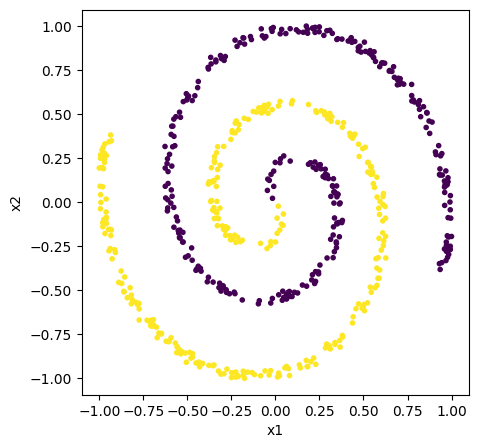

In [6]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [7]:
xx, yy = xx.to(device), yy.to(device)

In [8]:
class SoftmaxTemp(nn.Module):
    def __init__(self, temp=3.0):
        super().__init__()
        self.temp = temp
        
    def forward(self, x):
        return torch.softmax(x*self.temp, dim=-1)

In [9]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=10, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
#             dtnn.DistanceTransform_MinExp(2, h, bias=False),
#             SoftmaxTemp(10.0),
#             nn.BatchNorm1d(h),
#             nn.ELU(),
#             dtnn.OneActiv(h, mode="relu"),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [10]:
net = ResidualMLP(10).to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

criterion = nn.BCELoss()
# criterion = nn.MSELoss()

In [11]:
# print("_________________________")
# for epoch in range(5000):
#     yout = net(xx)
#     loss = criterion(yout, yy)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1)%100 == 0:
#         accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
#         print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

#     if (epoch+1)%1000 == 0:
#         ax = plt.figure(figsize=(6,6)).add_subplot()
#         out = (yout.data.cpu().numpy()>0.5).astype(int)
#         ax.scatter(x1, x2, c=out, marker= '.')
#         ## plot centroids
#         c = net.net[0].centers.data.cpu()
#         ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
#         plt.show()

In [12]:
# maxvals = net.net[:-1](xx).data.cpu().max(dim=1)[0]
# plt.hist(maxvals)

In [13]:
# yout = net(xx)
# ax = plt.figure(figsize=(6,5)).add_subplot()
# out = (yout.data.cpu().numpy()>0.5).astype(int)
# ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
# ## plot centroids
# c = net.net[0].centers.data.cpu()
# d = net.net[-1].weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()


# for i in range(c.shape[0]):
#     color = matplotlib.cm.tab10(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
#     ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# # plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
# plt.show()

## Actively choosing Data points as weights (w.r.t. SGD)

In [14]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=10, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [15]:
def directional_similarity(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
    
    ### direction towards +ve x-axis
    direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized

    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=1.5, dim=-1, keepdim=True)
    vecs_dirn = vecs/(vecs_mag+1e-11) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+1) ## gives inportance to similarity
    return yout

In [16]:
num_points = 100
X1 = np.linspace(-1.0, 1.0, num_points)
X2 = np.linspace(0.0, 2.0, num_points)

# X1 = np.linspace(-0.6, -0.4, num_points)
# X2 = np.linspace(0.9, 1.1, num_points)

X1, X2 = np.meshgrid(X1, X2)

XX_grid = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

In [21]:
point = torch.Tensor([[-0.5, 1]])
direction = torch.Tensor([[1, 0]])

In [22]:
sim = directional_similarity(point, direction, XX_grid)

In [23]:
## reduce output variance
# sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([-0.4343,  1.0101])


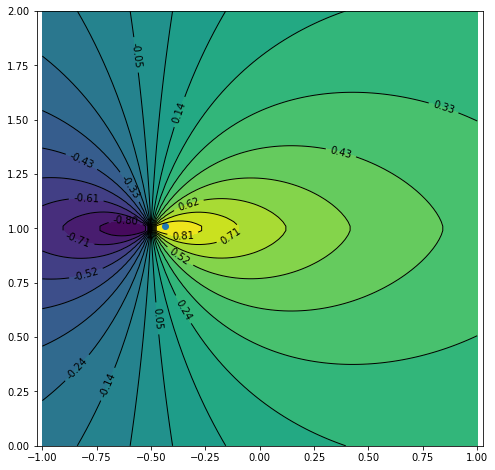

In [24]:
%matplotlib inline
LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max)
plt.axis('equal')
print(xx_max)

#### Directional Similarity Based On Gradient Magnitude

In [25]:
def directional_similarity_mag(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
    C = torch.Tensor([[0]]).to(point.device)
#     C = torch.norm(direction, p=2, dim=-1, keepdim=True)
#     print(C.shape)
    C = C.unsqueeze(1)
    
    ### direction towards +ve x-axis
#     direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
#     print(vecs.shape, vecs_mag.shape, C.shape)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+C) ## gives inportance to similarity
    return yout.squeeze(-1)

In [329]:
def directional_similarity_mag_v2(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    LP = 2
    C = torch.norm(direction, p=LP, dim=-1, keepdim=True)
    C = C.unsqueeze(1)
    
#     ### direction towards +ve x-axis
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=LP, dim=-1, keepdim=True)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
    yout = yout/(vecs_mag+1e-11+C) ## gives inportance to similarity
#     return (yout-C).squeeze(-1)


    LP = 2
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(point+direction, p=LP, dim=-1, keepdim=True)
#     C = C.unsqueeze(1)
    
    ### direction towards +ve x-axis
#     vecs = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    vecs2 = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    
    vecs2_mag = torch.norm(vecs, p=LP, dim=-1, keepdim=True)
    vecs2_dirn = vecs2/(vecs2_mag+1e-11+C) ## 1e-B for stability
    
    yout2 = torch.bmm(vecs2_dirn, direction.unsqueeze(2))## gives importance to direction
    yout2 = yout2/(vecs2_mag+1e-11+C) ## gives inportance to similarity
#     return yout.squeeze(-1)

#     print(yout.shape, vecs2_mag.shape)
    return (yout-yout2).squeeze(-1)

In [330]:
def directional_similarity_mag_v3(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    ### direction towards +ve x-axis

    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
    vecs_dirn = vecs/(vecs_mag+1e-11) ## 1e-B for stability
    
    direction = direction/torch.norm(direction, p=2, dim=-1, keepdim=True) ## always normalized

#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+1) ## gives inportance to similarity
    return yout

In [483]:
def directional_similarity_mag_v4(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    LP = 2
    vecs = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=LP, dim=-1, keepdim=True)
    return 1-vecs_mag.squeeze(-1)
#     return 1*torch.norm(direction)-vecs_mag.squeeze(-1)

In [484]:
def directional_similarity_mag_v5(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=2, dim=-1, keepdim=True)
    C = C.unsqueeze(1)
    
    ### Scale the points from target point (maybe even towwards the direction)
    
    vecs2 = other_points.unsqueeze(0)-(point+direction).unsqueeze(1)
    vecs2_mag = torch.norm(vecs2, p=2, dim=-1, keepdim=True).pow(5)#.exp()#.pow(5)
#     vecs2_mag = 0


    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
    yout = yout/(vecs_mag+vecs2_mag+1e-11+C) ## gives inportance to similarity
    return yout.squeeze(-1)

In [485]:
def directional_similarity_mag_v6(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    ## Since the maxima is at 1/2th the distance - direction is doubled to manage
    direction = direction*2
    
    
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=2, dim=-1, keepdim=True)
    C = C.unsqueeze(1)
    
    
    vecs = other_points.unsqueeze(0) - (point+direction).unsqueeze(1)
    vecs_mag_from_target = torch.norm(vecs, p=2, dim=-1, keepdim=True)
    
    vecs2 = other_points.unsqueeze(0) - (point).unsqueeze(1)
    vecs_mag = torch.norm(vecs2, p=2, dim=-1, keepdim=True)
    vecs_angle_from_source = vecs2/(vecs_mag+1e-11) ## 1e-B for stability
    
    vecs_mag_from_target = torch.maximum(vecs_mag, vecs_mag_from_target)
    
#     vecs_angle_from_source = torch.acos(vecs_angle_from_source)
    
    ### direction towards +ve x-axis
    direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized

#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_angle_from_source, direction.unsqueeze(2))## gives importance to direction
    yout = yout/(vecs_mag_from_target+1e-11) ## gives inportance to similarity
#     yout = yout*(vecs_mag_from_target) ## gives inportance to similarity
    yout = yout*C

    return yout.squeeze(-1)

In [486]:
point = torch.Tensor([[-0.5, 1]])
direction = torch.Tensor([[0.5, 0.5]])*0.1

In [487]:
num_points = 100

C = 1.3
## get dif in point and dirn
px, py = (point+direction*0.5)[0].tolist()
mag = (direction**2).sum().sqrt()

left = px-mag*C
right = px+mag*C
top = py-mag*C
bottom = py+mag*C


X1 = np.linspace(left, right, num_points)
X2 = np.linspace(top, bottom, num_points)
X1, X2 = np.meshgrid(X1, X2)
XX_grid = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

In [488]:
sim = directional_similarity_mag_v6(point, direction, XX_grid)
print(sim.max())

tensor(1.4122)


In [489]:
## reduce output variance
sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([[7.0155e-05, 7.0095e-05]])


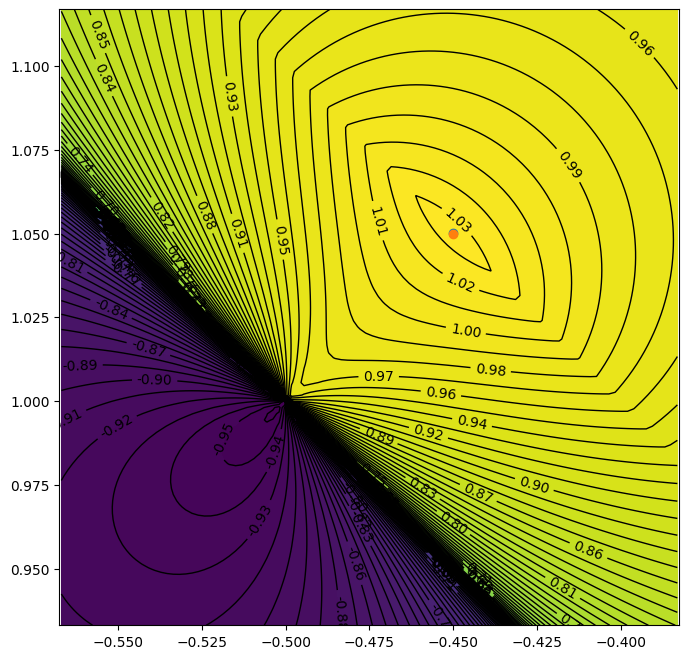

In [490]:
%matplotlib inline
LVLs=200
# LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max)
plt.scatter(*(point+direction).t())
plt.axis('equal')
print(xx_max-direction-point) ## should give zero for valid maximum


## Train At Once

In [667]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h, scale=10):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.BatchNorm1d(h),
#             nn.LayerNorm(h, elementwise_affine=False),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=scale, shift_init=0.0), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [694]:
net = ResidualMLP(10, scale=10.0).to(device)

lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()
LR = 0.01
# min_sim = 0.00 #-500## 0.0

In [695]:
net.net[0].centers.shape, net.net[-1].weight.shape

(torch.Size([10, 2]), torch.Size([2, 10]))

In [696]:
# torch.norm(net.net[-1].weight.data, dim=1, keepdim=True)

Epoch: 99, Acc:0.98, Loss:0.05939766764640808
Epoch: 199, Acc:0.99, Loss:0.0582597479224205
Epoch: 299, Acc:0.98, Loss:0.062085192650556564
Epoch: 399, Acc:1.00, Loss:0.0577813982963562
Epoch: 499, Acc:1.00, Loss:0.05675562098622322
Epoch: 599, Acc:0.97, Loss:0.06837674975395203
Epoch: 699, Acc:1.00, Loss:0.05636699125170708
Epoch: 799, Acc:0.98, Loss:0.05565197020769119
Epoch: 899, Acc:1.00, Loss:0.05402844771742821
Epoch: 999, Acc:0.99, Loss:0.053553786128759384


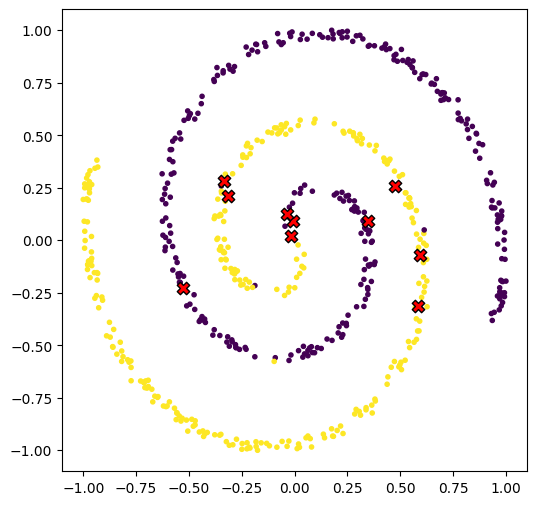

Epoch: 1099, Acc:0.99, Loss:0.053902920335531235
Epoch: 1199, Acc:1.00, Loss:0.05305827781558037
Epoch: 1299, Acc:1.00, Loss:0.05253058299422264
Epoch: 1399, Acc:0.99, Loss:0.05239935219287872
Epoch: 1499, Acc:1.00, Loss:0.05223103240132332
Epoch: 1599, Acc:0.99, Loss:0.05120436102151871
Epoch: 1699, Acc:1.00, Loss:0.051475655287504196
Epoch: 1799, Acc:0.98, Loss:0.052562423050403595
Epoch: 1899, Acc:0.98, Loss:0.05368609353899956
Epoch: 1999, Acc:1.00, Loss:0.04992147535085678


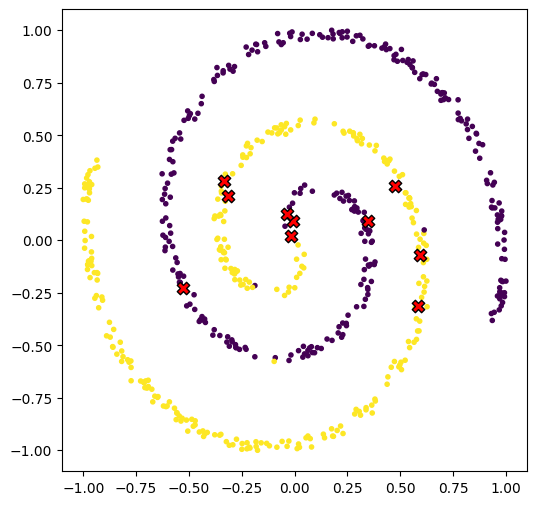

Epoch: 2099, Acc:0.99, Loss:0.04930983483791351
Epoch: 2199, Acc:0.99, Loss:0.04935215413570404
Epoch: 2299, Acc:0.98, Loss:0.05264734849333763
Epoch: 2399, Acc:0.99, Loss:0.049522288143634796
Epoch: 2499, Acc:0.98, Loss:0.05412277951836586
Epoch: 2599, Acc:0.98, Loss:0.05067335441708565
Epoch: 2699, Acc:1.00, Loss:0.04747556895017624
Epoch: 2799, Acc:0.99, Loss:0.04704049974679947
Epoch: 2899, Acc:1.00, Loss:0.04708181321620941
Epoch: 2999, Acc:0.98, Loss:0.053541701287031174


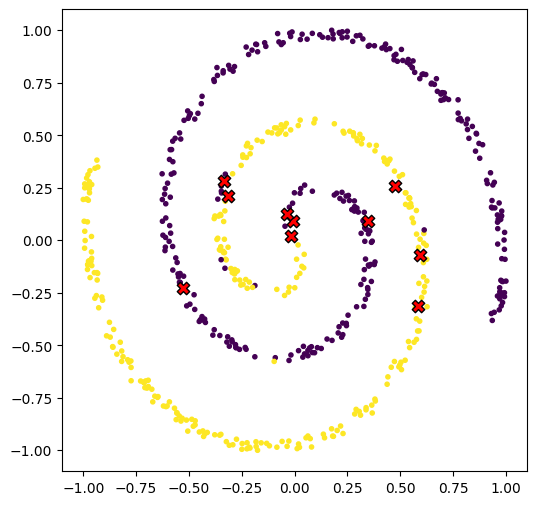

Epoch: 3099, Acc:0.99, Loss:0.05205338075757027
Epoch: 3199, Acc:0.99, Loss:0.04651540890336037
Epoch: 3299, Acc:0.99, Loss:0.04771792143583298
Epoch: 3399, Acc:1.00, Loss:0.04554310441017151
Epoch: 3499, Acc:1.00, Loss:0.04731575399637222
Epoch: 3599, Acc:1.00, Loss:0.04650711268186569
Epoch: 3699, Acc:0.97, Loss:0.05943302437663078
Epoch: 3799, Acc:1.00, Loss:0.04638464003801346
Epoch: 3899, Acc:0.99, Loss:0.04602048173546791
Epoch: 3999, Acc:0.98, Loss:0.04885341227054596


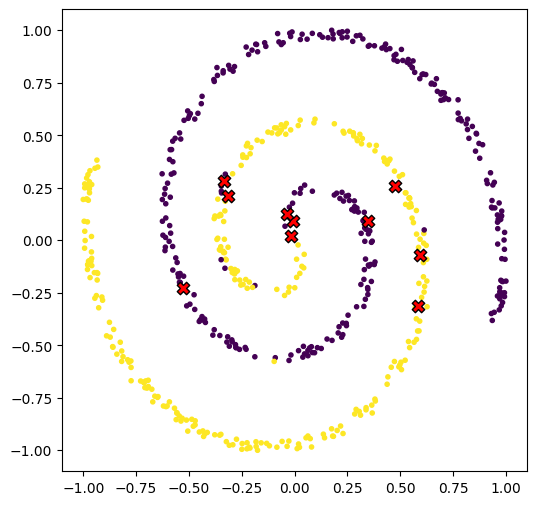

Epoch: 4099, Acc:0.99, Loss:0.044280003756284714
Epoch: 4199, Acc:1.00, Loss:0.04561407119035721
Epoch: 4299, Acc:1.00, Loss:0.04520038142800331
Epoch: 4399, Acc:0.98, Loss:0.052972935140132904
Epoch: 4499, Acc:0.99, Loss:0.04275544732809067
Epoch: 4599, Acc:0.99, Loss:0.04265301674604416
Epoch: 4699, Acc:1.00, Loss:0.043416302651166916
Epoch: 4799, Acc:1.00, Loss:0.04363790154457092
Epoch: 4899, Acc:1.00, Loss:0.04357118532061577
Epoch: 4999, Acc:0.99, Loss:0.04708695411682129


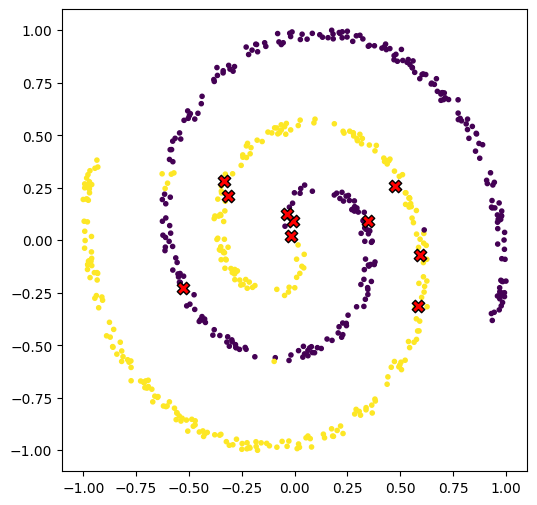

Epoch: 5099, Acc:1.00, Loss:0.04443691670894623
Epoch: 5199, Acc:0.98, Loss:0.04976113140583038
Epoch: 5299, Acc:1.00, Loss:0.03791964799165726
Epoch: 5399, Acc:1.00, Loss:0.03571496903896332
Epoch: 5499, Acc:1.00, Loss:0.03531267121434212
Epoch: 5599, Acc:1.00, Loss:0.034937720745801926
Epoch: 5699, Acc:1.00, Loss:0.034575916826725006
Epoch: 5799, Acc:1.00, Loss:0.034223031252622604
Epoch: 5899, Acc:1.00, Loss:0.03387764096260071
Epoch: 5999, Acc:1.00, Loss:0.033538009971380234


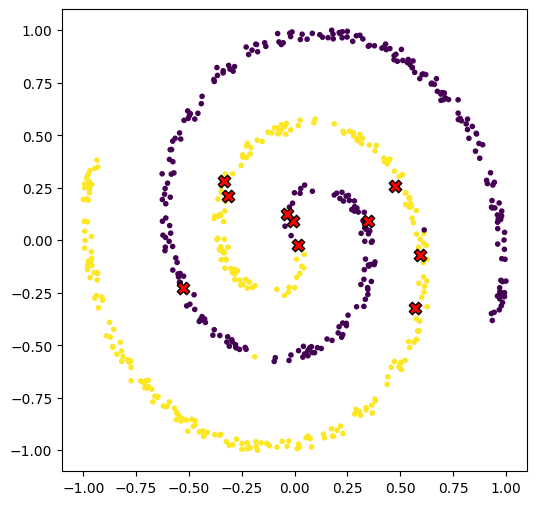

Epoch: 6099, Acc:1.00, Loss:0.0332038514316082
Epoch: 6199, Acc:1.00, Loss:0.03387168049812317
Epoch: 6299, Acc:1.00, Loss:0.032621920108795166
Epoch: 6399, Acc:1.00, Loss:0.03232214227318764
Epoch: 6499, Acc:1.00, Loss:0.03203391283750534
Epoch: 6599, Acc:1.00, Loss:0.03175275772809982
Epoch: 6699, Acc:1.00, Loss:0.031601957976818085
Epoch: 6799, Acc:1.00, Loss:0.03130662068724632
Epoch: 6899, Acc:1.00, Loss:0.03103683516383171
Epoch: 6999, Acc:1.00, Loss:0.032415855675935745


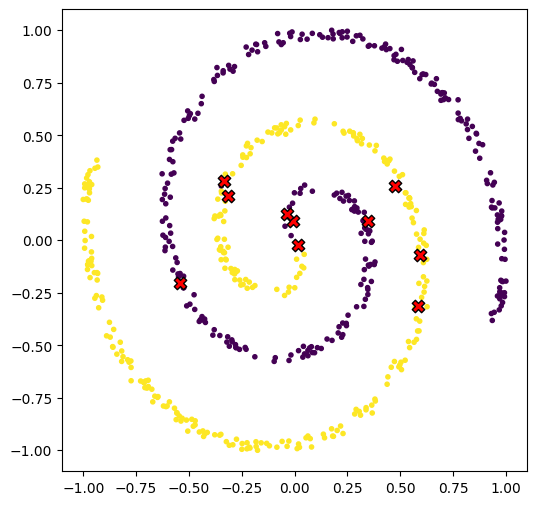

KeyboardInterrupt: 

In [698]:
for epoch in range(10000):
    wnorm = torch.norm(net.net[-1].weight.data, dim=0, keepdim=True)
    net.net[-1].weight.data *= wnorm.clamp(0.01, 2.0)/wnorm
    
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    ########################################################
    ### Do discrete optimization here
    if (epoch+0)%5 <= 0:
        sim = directional_similarity_mag_v4( ## V4 is magnitude
#         sim = directional_similarity_mag_v6( ## V6 is max of-> mag, dirn
                    net.net[0].centers, 
                    -net.net[0].centers.grad * LR, 
                    xx)
        
        ## Method 1 (no filtering)
        if epoch == 0:
            sim_x = sim.argmax(dim=-1)
            net.net[0].centers.data = xx[sim_x]
        else:
        ## Method 2 (filtering)
            maxval, maxidx = sim.max(dim=-1)
            valid_mask = maxval > min_sim
            net.net[0].centers.data[valid_mask] = xx[maxidx][valid_mask]
    
    ########################################################
#         optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    else:
        net.net[0].centers.grad = None
        optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], facecolor='red', marker= 'X', edgecolor='k', s=80)
        plt.show()

In [691]:
sim.max(), sim.min()

(tensor(1.6087, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-0.4567, device='cuda:0', grad_fn=<MinBackward1>))

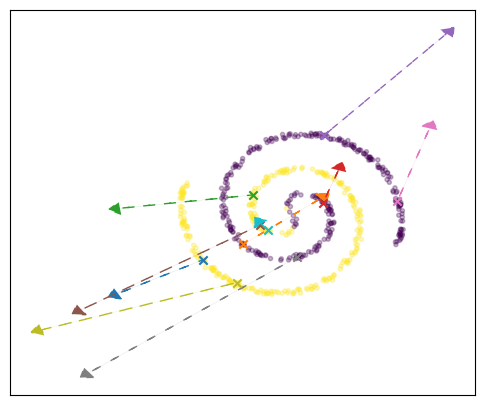

In [692]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*1.0 + net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

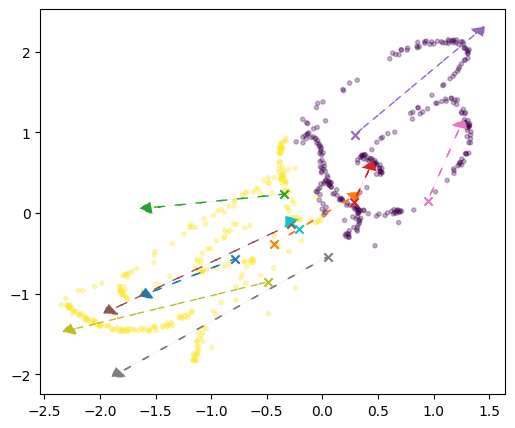

In [693]:
dev = (xx+net.net(xx)*1.0).data.cpu()

ax = plt.figure(figsize=(6,5)).add_subplot()

ax.scatter(dev[:,0], dev[:,1], c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*1.0 + net.net[-1].bias.data.cpu()
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_1.pdf", bbox_inches='tight')
plt.show()